In [27]:
import torch
import numpy as np
import os, sys
import shutil
import pickle
import cv2
from tqdm import tqdm
from sklearn.cluster import KMeans
from datetime import datetime
import matplotlib.pyplot as plt

sys.path.insert(0, 'src')
from utils.utils import ensure_dir, read_json, informal_log
from utils.visualizations import plot
from utils.model_utils import prepare_device

import model.metric as module_metric
import model.loss as module_loss
import datasets.datasets as module_data

from train import main as train_fn
from predict import predict
from parse_config import ConfigParser


sys.path.insert(0, 'setup')
from setup_cifar10 import setup_cifar10 
# import cv2
# print(cv2.__version__)

In [24]:
cifar10_save_dir = os.path.join('saved', 'cifar10')
processed_cifar_dir = 'data/cifar10-processed'

ensure_dir(cifar10_save_dir)

### Process CIFAR-10 to get rid of bytes

In [3]:
raw_cifar_dir = 'data/cifar-10-batches-py'

if not os.path.exists(processed_cifar_dir):
    setup_cifar_10(
        raw_cifar_dir=raw_cifar_dir,
        processed_cifar_dir=processed_cifar_dir)
    print("Processing CIFAR10")
else:
    print("CIFAR-10 already processed at {}".format(processed_cifar_dir))
    

CIFAR-10 already processed at data/cifar10-processed


### Datasets for CIFAR10

In [25]:
from torch.utils.data import Dataset
from torchvision import transforms
from utils.visualizations import show_image

class CIFAR10Dataset():
    def __init__(self,
                 cifar_dir, 
                 split):
                 # normalize=False,
                 # means=[0.4914, 0.4822, 0.4465],
                 # stds=[0.2471, 0.2435, 0.2616]):
        
        assert split in ['train', 'test'], "Invalid split '{}'. Must be 'train' or 'test'".format(split)
        if split == 'train':
            files = ['data_batch_{}'.format(i) for i in range(1,6)]
        else:
            files = ['test_batch']
            
        images = []
        labels = []
        for file in files:
            path = os.path.join(cifar_dir, file)
            data = pickle.load(open(path, 'rb'))
            cur_images = data['data']
            cur_images = np.reshape(cur_images, (-1, 3, 32, 32))
            images.append(cur_images)
            
            cur_labels = np.array(data['labels'])
            labels.append(cur_labels)
        
        self.images = np.concatenate(images, axis=0)
        self.images = np.transpose(self.images, (0, 2, 3, 1)) # N x H x W x C
        
#         if normalize:
#             means = np.tile(means, (*self.images.shape[:3], 1))
#             stds = np.tile(stds, (*self.images.shape[:3], 1))
            
#             self.images = (self.images - means) / stds
#             print(means.shape)
#             print(means[0, :, 0, 0])
            # self.images = 
        self.labels = np.concatenate(labels, axis=0)
        self.n_samples = len(self.labels)
        
    def get_images(self):
        return self.images

    def get_labels(self):
        return self.labels
        
    def __len__(self):
        return self.n_samples
    
train_dataset = CIFAR10Dataset(
    cifar_dir=processed_cifar_dir,
    split='train')
        
train_images = train_dataset.get_images()
train_labels = train_dataset.get_labels()

test_dataset = CIFAR10Dataset(
    cifar_dir=processed_cifar_dir,
    split='test')
test_images = test_dataset.get_images()
test_labels = test_dataset.get_labels()

### CIFAR10 dataset for torch models

In [173]:
class CIFAR10TorchDataset(Dataset):
    def __init__(self,
                 cifar_dir,
                 split,
                 to_tensor=True,
                 normalize=True,
                 means=[0.4914, 0.4822, 0.4465],
                 stds=[0.2471, 0.2435, 0.2616]):
        
        images = []
        labels = []
        assert split in ['train', 'test'], "Invalid split '{}'. Must be 'train' or 'test'".format(split)
        if split == 'train':
            files = ['data_batch_{}'.format(i) for i in range(1,6)]
        else:
            files = ['test_batch']
            
        for file in files:
            path = os.path.join(cifar_dir, file)
            data = pickle.load(open(path, 'rb'))
            cur_images = data['data']
            cur_images = np.reshape(cur_images, (-1, 3, 32, 32))
            images.append(cur_images)
            
            cur_labels = np.array(data['labels'])
            labels.append(cur_labels)
        
        self.images = np.concatenate(images, axis=0)
        self.images = np.transpose(self.images, (0, 2, 3, 1))
        self.labels = np.concatenate(labels, axis=0)
        self.n_samples = len(self.labels)
                
        # Create transformations
        self.transforms = [transforms.ToTensor()]  # changes dims H x W x C -> C x H x W and scales to [0, 1]
        if normalize:
            self.transforms.append(transforms.Normalize(means, stds))
        self.transforms = transforms.Compose(self.transforms)
    
    def __getitem__(self, idx):
        image = self.transforms(self.images[idx])
        label = self.labels[idx]
        return image, label

    def __len__(self):
        return self.n_samples
        
train_dataset = CIFAR10(
    cifar_dir=processed_cifar_dir,
    split='train',
    to_tensor=False,
    normalize=False)

test_dataset = CIFAR10(
    cifar_dir=processed_cifar_dir,
    split='test',
    to_tensor=False,
    normalize=False)

### OpenCV's SIFT
Tutorial from [here](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)

In [32]:
MAX_FEATURES = 32
RESIZE = (128, 128)
descriptor_size = 128
debug = False


sift = cv2.SIFT_create()
train_keypoints = []
train_descriptors = []

images = {
    'train': train_images,
    'test': test_images
}
sift_data = {
    'train': {
        'keypoints': [],
        'descriptors': []
    },
    'test': {
        'keypoints': [],
        'descriptors': []
    }
}
for split in ['train', 'test']:
    print("Calculating keypoints and feature descriptors for CIFAR-10 {} split".format(split))
    split_images = images[split]
    split_keypoints = sift_data[split]['keypoints']
    split_descriptors = sift_data[split]['descriptors']
    for idx, image in enumerate(tqdm(split_images, total=len(split_images))):
        if debug and idx == 5:
            break
        # Image processing
        image = cv2.resize(image, RESIZE)
        image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Calculate descriptors
        keypoints, descriptors = sift.detectAndCompute(image_bw, None)
        if debug:
            img2 = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)
            plt.imshow(img2)
            plt.show()
        if len(keypoints) == 0:
            descriptors = np.zeros((1, descriptor_size), np.float32)
        keypoint_objs = []
        for keypoint in keypoints:
            keypoint_objs.append({
                'point': keypoint.pt,
                'size': keypoint.size,
                'angle': keypoint.angle,
                'response': keypoint.response,
                'octave': keypoint.octave,
                'class_id': keypoint.class_id
            })
        split_keypoints.append(keypoint_objs)
        split_descriptors.append(descriptors)
        
    sift_data[split]['keypoints'] = split_keypoints
    sift_data[split]['descriptors'] = split_descriptors


Calculating keypoints and feature descriptors for CIFAR-10 train split


100%|████████████████████████████████████| 50000/50000 [03:11<00:00, 260.65it/s]


Calculating keypoints and feature descriptors for CIFAR-10 test split


100%|████████████████████████████████████| 10000/10000 [00:38<00:00, 257.68it/s]


In [34]:
assert len(sift_data['test']['keypoints']) == len(test_images)
assert len(sift_data['test']['descriptors']) == len(test_images)
assert len(sift_data['train']['keypoints']) == len(train_images)
assert len(sift_data['train']['descriptors']) == len(train_images)
# assert 
sift_save_path = os.path.join(cifar10_save_dir, 
                              'sift_{}_{}'.format(RESIZE[0], RESIZE[1]), 
                              'sift_keypoints_descriptors.pth')
ensure_dir(os.path.dirname(sift_save_path))
if not os.path.exists(sift_save_path):
    torch.save(sift_data, sift_save_path)
    print("Saved keypoints & descriptors from train and test to {}".format(sift_save_path))
else:
    print("Path {} already exists".format(sift_save_path))

Saved keypoints & descriptors from train and test to saved/cifar10/sift_128_128/sift_keypoints_descriptors.pth


### Cluster the feature descriptors

In [35]:
sift_data_path = 'saved/cifar10/sift_{}_{}/sift_keypoints_descriptors.pth'.format(
    RESIZE[0], RESIZE[1])
sift_data = torch.load(sift_data_path)
train_descriptors = sift_data['train']['descriptors']
flat_train_descriptors = np.concatenate(train_descriptors, axis=0)
print(flat_train_descriptors.shape)

(1613209, 128)


#### Hyperparameter search for the optimal number of clusters

In [ ]:
ks = [5, 10, 50, 75, 100, 150]
n_init = 10
inertias = []

for k in ks:
    print("Calculating k-means for k={}".format(k))
    kmeans = KMeans(n_clusters=k, n_init=n_init)
    kmeans = kmeans.fit(flat_train_descriptors)
    print("Inertia: {}".format(kmeans.inertia_))
    inertias.append(kmeans.inertia_)
    
plot(
    xs=ks,
    ys=inertias)

Calculating k-means for k=5
Calculating k-means for k=10
Calculating k-means for k=50
Calculating k-means for k=75


[5, 10, 50, 75, 100, 150] [205773570048.0, 189882646528.0, 158591074304.0, 151840161792.0, 147232325632.0, 141014695936.0]


(<Figure size 432x288 with 1 Axes>, <Axes: >)

<Figure size 432x288 with 0 Axes>

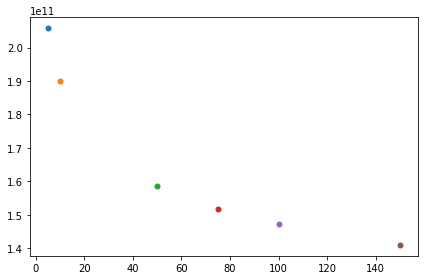

In [41]:
print(ks, inertias)
plot(
    xs=ks,
    ys=inertias)

#### Make clusters 

In [42]:
k = 50
n_init = 10
print("Calculating kmeans clusters with k={}".format(k))
kmeans = KMeans(n_clusters=k, n_init=n_init)
kmeans = kmeans.fit(flat_train_descriptors)


Calculating kmeans clusters with k=50


In [43]:
kmeans_save_path = os.path.join(cifar10_save_dir, 
                                'sift_{}_{}'.format(RESIZE[0], RESIZE[1]),
                                '{}means'.format(k), 
                                'descriptor_kmeans.pth')
ensure_dir(os.path.dirname(kmeans_save_path))
if not os.path.exists(kmeans_save_path):
    torch.save(kmeans, kmeans_save_path)
    print("K-means with k={} saved to '{}".format(k, kmeans_save_path))
else:
    print("K-means model already saved to {}".format(kmeans_save_path))

K-means with k=50 saved to 'saved/cifar10/sift_128_128/50means/descriptor_kmeans.pth


#### For each descriptor in training and test set, create a histogram representing the features present

In [45]:
kmeans_path = os.path.join(cifar10_save_dir, 
                                'sift_{}_{}'.format(RESIZE[0], RESIZE[1]),
                                '{}means'.format(k), 
                                'descriptor_kmeans.pth')

kmeans = torch.load(kmeans_path)
debug = False

histogram_data = {}
# for split, descriptors in zip(['train', 'test'], [train_descriptors, test_descriptors]):
for split in ['train', 'test']:
    descriptors = sift_data[split]['descriptors']
    histogram_vectors = []

    for idx, image_descriptors in enumerate(tqdm(descriptors, total=len(descriptors))):
        if debug and idx == 5:
            break
        n_descriptors = len(image_descriptors)
        descriptor_clusters = kmeans.predict(image_descriptors)
        histogram = np.zeros(k)
        for cluster_idx in descriptor_clusters:
            histogram[cluster_idx] += 1 / n_descriptors  # add 1/n_descriptors bc histogram will be normalized

        histogram_vectors.append(histogram)
    histogram_vectors = np.stack(histogram_vectors, axis=0)
    histogram_data[split] = histogram_vectors


100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 3818.16it/s]


In [46]:
print("Train shape: {} Test shape: {}".format(histogram_data['train'].shape, histogram_data['test'].shape))
histogram_vectors_save_path = os.path.join(os.path.dirname(kmeans_path), 'histogram_vectors.pth')
if not os.path.exists(histogram_vectors_save_path):
    torch.save(histogram_data, histogram_vectors_save_path)
    print("Saved train histogram vectors to {}".format(histogram_vectors_save_path))
else:
    print("Histogram vectors already exists at {}".format(histogram_vectors_save_path))

Train shape: (50000, 50) Test shape: (10000, 50)
Saved train histogram vectors to saved/cifar10/sift_128_128/50means/histogram_vectors.pth


### Get CIFAR10 model's predictions

In [170]:
sys.path.insert(0, 'src')
from model.base_model import BaseModel
sys.path.insert(0, os.path.join('external_code', 'PyTorch_CIFAR10'))
# from cifar10_models.densenet import densenet121, densenet161, densenet169
# from cifar10_models.googlenet import googlenet
# from cifar10_models.inception import inception_v3
# from cifar10_models.mobilenetv2 import mobilenet_v2
from cifar10_models.resnet import resnet18, resnet34, resnet50

class CIFAR10PretrainedModel(BaseModel):
    '''
    Simple model wrapper for models in external_code/PyTorch_CIFAR10/cifar10_models/state_dicts

    Arg(s):
        type : str
            Name of architecture, must be key in self.all_classifiers

    '''
    def __init__(self,
                 type,
                 checkpoint_path="",
                 device=None):
        super().__init__()
        self.all_classifiers = {
            # "vgg11_bn": vgg11_bn(),
            # "vgg13_bn": vgg13_bn(),
            # "vgg16_bn": vgg16_bn(),
            # "vgg19_bn": vgg19_bn(),
            "resnet18": resnet18(),
            "resnet34": resnet34(),
            "resnet50": resnet50(),
            # "densenet121": densenet121(),
            # "densenet161": densenet161(),
            # "densenet169": densenet169(),
            # "mobilenet_v2": mobilenet_v2(),
            # "googlenet": googlenet(),
            # "inception_v3": inception_v3()
        }
        if type not in self.all_classifiers:
            raise ValueError("Architecture {} not available for pretrained CIFAR-10 models".format(type))
        self.model = self.all_classifiers[type]
        # self.softmax = torch.nn.Softmax(dim=1)

        # Restore weights if checkpoint_path is valid
        self.checkpoint_path = checkpoint_path

        if self.checkpoint_path != "":
            try:
                self.restore_model(checkpoint_path)
            except:
                checkpoint = torch.load(checkpoint_path)
                self.model.load_state_dict(checkpoint)

        # Store parameters
        self.model_parameters = list(filter(lambda p: p.requires_grad, self.parameters()))
        self.n_params = sum([np.prod(p.size()) for p in self.model_parameters])

    def forward(self, x):
        self.logits = self.model(x)
        return self.logits

    def get_features(self, x):
        features = self.model.features(x)
        return features

    def get_checkpoint_path(self):
        return self.checkpoint_path

    def get_n_params(self):
        return self.n_params

In [176]:
# Create model and load data loaders
cifar10_resnet18 = CIFAR10PretrainedModel(
    type='resnet18',
    checkpoint_path='/n/fs/ac-alignment/explain-alignment/checkpoints/cifar10_state_dicts/resnet18.pt')

cifar10_train_dataset = CIFAR10TorchDataset(
    cifar_dir=processed_cifar_dir,
    split='train')
cifar10_train_dataloader = torch.utils.data.DataLoader(
    cifar10_train_dataset,
    shuffle=False,
    batch_size=256,
    num_workers=8)

cifar10_test_dataset = CIFAR10TorchDataset(
    cifar_dir=processed_cifar_dir,
    split='test')
cifar10_test_dataloader = torch.utils.data.DataLoader(
    cifar10_test_dataset,
    shuffle=False,
    batch_size=256,
    num_workers=8)

In [184]:
device, _ = prepare_device(n_gpu_use=1)
cifar10_resnet18 = cifar10_resnet18.to(device)
metric_fns = [getattr(module_metric, 'accuracy')]


train_predict_log = predict(
    data_loader=cifar10_train_dataloader,
    model=cifar10_resnet18,
    metric_fns=metric_fns,
    device=device)

test_predict_log = predict(
    data_loader=cifar10_test_dataloader,
    model=cifar10_resnet18,
    metric_fns=metric_fns,
    device=device)
    

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.20it/s]


In [198]:
# Save outputs
save_path = os.path.join('saved', 'cifar10', 'resnet18', 'outputs_predictions.pth')
ensure_dir(os.path.dirname(save_path_template))
save_data = {}
for split, logs in zip(['train', 'test'], [train_predict_log, test_predict_log]):
    outputs = logs['logits']
    probabilities = torch.softmax(outputs, dim=1)
    predictions = torch.argmax(outputs, dim=1)
    
    outputs = outputs.cpu().numpy()
    probabilities = probabilities.cpu().numpy()
    predictions = predictions.cpu().numpy()
    
    split_data = {
        'outputs': outputs,
        'probabilities': probabilities,
        'predictions': predictions,
        'accuracy': logs['metrics']['accuracy']
    }
    save_data[split] = split_data

if not os.path.exists(save_path):
    torch.save(save_data, save_path)
    print("Saved train/test outputs to {}".format(save_path))
else:
    print("Train/test results already saved to {}".format(save_path)) 
        

Saved train/test outputs to saved/cifar10/resnet18/outputs_predictions.pth


### Train linear layer to predict model's soft label outputs from histogram features

#### Hyperparam search

In [2]:
# config_path = 'configs/train_cifar10_sift_explainer.json'
# debug = False
# if debug:
#     learning_rates = [1e-6] #, 1e-5, 1e-4, 1e-3, 5e-2, 1e-2, 5e-1, 1e-1]
#     weight_decays = [0, 1e-1] #, 1e-2, 1e-3]
# else:
#     learning_rates = [1e-6, 1e-5, 1e-4, 1e-3, 5e-2, 1e-2, 5e-1, 1e-1]
#     weight_decays = [0, 1e-1, 1e-2, 1e-3]

# config_json = read_json(config_path)


In [3]:
# dataset_args = config_json['dataset']['args']
# train_descriptors_dataset = module_data.KDDataset(split='train', **dataset_args)
# test_descriptors_dataset = module_data.KDDataset(split='test', **dataset_args)

# dataloader_args = config_json['data_loader']['args']
# train_descriptors_dataloader = torch.utils.data.DataLoader(
#     train_descriptors_dataset,
#     shuffle=True,
#     **dataloader_args)
# test_descriptors_dataloader = torch.utils.data.DataLoader(
#     test_descriptors_dataset,
#     shuffle=False,
#     **dataloader_args)

In [4]:
# best = {
#     'lr': -1,
#     'wd': -1,
#     'val_acc': -1
# }
# n_trials = len(learning_rates) * len(weight_decays)
# trial_idx = 1
# timestamp = datetime.now().strftime(r'%m%d_%H%M%S')

# # Logging
# log_path = os.path.join(config_json['trainer']['save_dir'], timestamp, 'log.txt')
# ensure_dir(os.path.dirname(log_path))
# informal_log("Hyperparameter search", log_path)
# informal_log("Learning rates: {}".format(learning_rates), log_path)
# informal_log("Weight decays: {}".format(weight_decays), log_path)

# # Debug mode
# if debug:
#     config_json['trainer']['epochs'] = 1
    
# for lr in learning_rates:
#     for wd in weight_decays:
#         # Update config json
#         config_json['optimizer']['args'].update({
#             'lr': lr,
#             'weight_decay': wd
#         })
        
#         # Create run ID for trial
#         itr_timestamp = datetime.now().strftime(r'%m%d_%H%M%S')
#         informal_log("[{}] Trial {}/{}: LR = {} WD = {}".format(
#             itr_timestamp, trial_idx, n_trials, lr, wd), log_path)
#         run_id = os.path.join(timestamp, 'trials', 'lr_{}-wd_{}'.format(lr, wd))
#         config = ConfigParser(config_json, run_id=run_id)
#         print(config.config['optimizer']['args'])
        
#         # Train model
#         model = train_fn(
#             config=config, 
#             train_data_loader=train_descriptors_dataloader,
#             val_data_loader=test_descriptors_dataloader)
        
#         # Restore model
#         model_restore_path = os.path.join(config.save_dir, 'model_best.pth')
        
#         model.restore_model(model_restore_path)
#         print("restored model")
#         # Run on validation set using predict function
#         device, device_ids = prepare_device(config_json['n_gpu'])
#         metric_fns = [getattr(module_metric, met) for met in config_json['metrics']]
#         loss_fn = getattr(module_loss, config_json['loss'])
#         trial_path = os.path.dirname(os.path.dirname(model_restore_path))
#         output_save_path = os.path.join(trial_path, "val_outputs.pth")
#         log_save_path = os.path.join(trial_path, "val_metrics.pth")
        
#         validation_data = predict(
#             data_loader=test_descriptors_dataloader,
#             model=model,
#             metric_fns=metric_fns,
#             device=device,
#             loss_fn=loss_fn,
#             output_save_path=output_save_path,
#             log_save_path=log_save_path)
       
#         # Obtain accuracy and compare to previous best
#         print(validation_data['metrics'].keys())
#         val_accuracy = validation_data['metrics']['accuracy']
#         if val_accuracy > best['val_acc']:
#             best.update({
#                 'lr': lr,
#                 'wd': wd,
#                 'val_acc': val_accuracy
#             })
#             informal_log("Best accuracy of {:.3f} with lr={} and wd={}".format(val_accuracy, lr, wd), log_path)
#             informal_log("Trial path: {}".format(trial_path), log_path)
#             # Copy model and outputs to 1 directory for easy access
#             best_save_dir = os.path.join(os.path.dirname(os.path.dirname(trial_path)), 'best')
#             ensure_dir(best_save_dir)
#             best_outputs_save_path = os.path.join(best_save_dir, 'outputs.pth')
#             best_model_save_path = os.path.join(best_save_dir, 'model.pth')
#             torch.save(validation_data['logits'], best_outputs_save_path)
#             model.save_model(best_model_save_path)
#             informal_log("Saved model and outputs to {}".format(best_save_dir), log_path)
            
            
#         trial_idx += 1

Hyperparameter search
Learning rates: [1e-06, 1e-05, 0.0001, 0.001, 0.05, 0.01, 0.5, 0.1]
Weight decays: [0, 0.1, 0.01, 0.001]
[0525_102954] Trial 1/32: LR = 1e-06 WD = 0
OrderedDict([('lr', 1e-06), ('weight_decay', 0), ('amsgrad', False)])
Created LinearLayers model with 760 trainable parameters
Training from scratch.
Checkpoint save directory: saved/cifar10/resnet18/explainer/sift_descriptor_histogram/hparam_search/0525_102954/trials/lr_1e-06-wd_0/models
Train Epoch: 1 [0/196 (0%)] Loss: 2.308654
Train Epoch: 1 [48/196 (24%)] Loss: 2.301465
Train Epoch: 1 [96/196 (49%)] Loss: 2.310005
Train Epoch: 1 [144/196 (73%)] Loss: 2.310523
Train Epoch: 1 [192/196 (98%)] Loss: 2.302329
    epoch          : 1
    val_TP         : [  0   0 155 473   0   3   0 415   0   0]
    val_TN         : [8984 9010 7295 4802 8988 8976 9019 5996 8982 8994]
    val_FPs        : [   0    0 1703 4206    5   22    0 3018    0    0]
    val_FNs        : [1016  990  847  519 1007  999  981  571 1018 1006]
    val_a

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 2 [0/196 (0%)] Loss: 2.304604
Train Epoch: 2 [48/196 (24%)] Loss: 2.306756
Train Epoch: 2 [96/196 (49%)] Loss: 2.298509
Train Epoch: 2 [144/196 (73%)] Loss: 2.298776
Train Epoch: 2 [192/196 (98%)] Loss: 2.316076
    epoch          : 2
    val_TP         : [  0   0 155 473   0   3   0 415   0   0]
    val_TN         : [8984 9010 7296 4801 8988 8975 9019 5997 8982 8994]
    val_FPs        : [   0    0 1702 4207    5   23    0 3017    0    0]
    val_FNs        : [1016  990  847  519 1007  999  981  571 1018 1006]
    val_accuracy   : 0.1046
    val_per_class_accuracy: [0.8984 0.901  0.7451 0.5274 0.8988 0.8978 0.9019 0.6412 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8209199999999999
    val_precision  : [0.         0.         0.08346796 0.10106838 0.         0.11538462
 0.         0.12092075 0.         0.        ]
    val_precision_mean: 0.04208416964475123
    val_recall     : [0.         0.         0.15469062 0.47681452 0.         0.00299401
 0.         0.42089249 0

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 3 [0/196 (0%)] Loss: 2.299911
Train Epoch: 3 [48/196 (24%)] Loss: 2.309268
Train Epoch: 3 [96/196 (49%)] Loss: 2.301476
Train Epoch: 3 [144/196 (73%)] Loss: 2.306011
Train Epoch: 3 [192/196 (98%)] Loss: 2.303592
    epoch          : 3
    val_TP         : [  0   0 155 475   0   3   0 414   0   0]
    val_TN         : [8984 9010 7299 4800 8988 8973 9019 5998 8982 8994]
    val_FPs        : [   0    0 1699 4208    5   25    0 3016    0    0]
    val_FNs        : [1016  990  847  517 1007  999  981  572 1018 1006]
    val_accuracy   : 0.1047
    val_per_class_accuracy: [0.8984 0.901  0.7454 0.5275 0.8988 0.8976 0.9019 0.6412 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8209399999999999
    val_precision  : [0.         0.         0.08360302 0.10143071 0.         0.10714286
 0.         0.12069971 0.         0.        ]
    val_precision_mean: 0.04128762929057648
    val_recall     : [0.         0.         0.15469062 0.47883065 0.         0.00299401
 0.         0.4198783  0

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 4 [0/196 (0%)] Loss: 2.295830
Train Epoch: 4 [48/196 (24%)] Loss: 2.308899
Train Epoch: 4 [96/196 (49%)] Loss: 2.302775
Train Epoch: 4 [144/196 (73%)] Loss: 2.301301
Train Epoch: 4 [192/196 (98%)] Loss: 2.303488
    epoch          : 4
    val_TP         : [  0   0 156 475   0   3   0 414   0   0]
    val_TN         : [8984 9010 7301 4799 8988 8973 9019 5998 8982 8994]
    val_FPs        : [   0    0 1697 4209    5   25    0 3016    0    0]
    val_FNs        : [1016  990  846  517 1007  999  981  572 1018 1006]
    val_accuracy   : 0.1048
    val_per_class_accuracy: [0.8984 0.901  0.7457 0.5274 0.8988 0.8976 0.9019 0.6412 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.82096
    val_precision  : [0.         0.         0.0841878  0.10140905 0.         0.10714286
 0.         0.12069971 0.         0.        ]
    val_precision_mean: 0.04134394212516882
    val_recall     : [0.         0.         0.15568862 0.47883065 0.         0.00299401
 0.         0.4198783  0.         0

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 5 [0/196 (0%)] Loss: 2.304317
Train Epoch: 5 [48/196 (24%)] Loss: 2.311249
Train Epoch: 5 [96/196 (49%)] Loss: 2.303680
Train Epoch: 5 [144/196 (73%)] Loss: 2.299185
Train Epoch: 5 [192/196 (98%)] Loss: 2.301899
    epoch          : 5
    val_TP         : [  0   0 157 475   0   3   0 415   0   0]
    val_TN         : [8984 9010 7302 4801 8988 8973 9019 5997 8982 8994]
    val_FPs        : [   0    0 1696 4207    5   25    0 3017    0    0]
    val_FNs        : [1016  990  845  517 1007  999  981  571 1018 1006]
    val_accuracy   : 0.105
    val_per_class_accuracy: [0.8984 0.901  0.7459 0.5276 0.8988 0.8976 0.9019 0.6412 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8210000000000001
    val_precision  : [0.         0.         0.08472747 0.10145237 0.         0.10714286
 0.         0.12092075 0.         0.        ]
    val_precision_mean: 0.04142434428145594
    val_recall     : [0.         0.         0.15668663 0.47883065 0.         0.00299401
 0.         0.42089249 0.

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 6 [0/196 (0%)] Loss: 2.298853
Train Epoch: 6 [48/196 (24%)] Loss: 2.314916
Train Epoch: 6 [96/196 (49%)] Loss: 2.305901
Train Epoch: 6 [144/196 (73%)] Loss: 2.306633
Train Epoch: 6 [192/196 (98%)] Loss: 2.306074
    epoch          : 6
    val_TP         : [  0   0 157 475   0   3   0 415   0   0]
    val_TN         : [8984 9010 7300 4805 8988 8973 9019 5995 8982 8994]
    val_FPs        : [   0    0 1698 4203    5   25    0 3019    0    0]
    val_FNs        : [1016  990  845  517 1007  999  981  571 1018 1006]
    val_accuracy   : 0.105
    val_per_class_accuracy: [0.8984 0.901  0.7457 0.528  0.8988 0.8976 0.9019 0.641  0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8210000000000001
    val_precision  : [0.         0.         0.08463612 0.10153912 0.         0.10714286
 0.         0.12085032 0.         0.        ]
    val_precision_mean: 0.04141684153491344
    val_recall     : [0.         0.         0.15668663 0.47883065 0.         0.00299401
 0.         0.42089249 0.

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 7 [0/196 (0%)] Loss: 2.315527
Train Epoch: 7 [48/196 (24%)] Loss: 2.300157
Train Epoch: 7 [96/196 (49%)] Loss: 2.307732
Train Epoch: 7 [144/196 (73%)] Loss: 2.299602
Train Epoch: 7 [192/196 (98%)] Loss: 2.307986
    epoch          : 7
    val_TP         : [  0   0 157 474   0   3   0 415   0   0]
    val_TN         : [8984 9010 7298 4806 8988 8973 9019 5995 8982 8994]
    val_FPs        : [   0    0 1700 4202    5   25    0 3019    0    0]
    val_FNs        : [1016  990  845  518 1007  999  981  571 1018 1006]
    val_accuracy   : 0.1049
    val_per_class_accuracy: [0.8984 0.901  0.7455 0.528  0.8988 0.8976 0.9019 0.641  0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8209799999999999
    val_precision  : [0.         0.         0.08454496 0.10136869 0.         0.10714286
 0.         0.12085032 0.         0.        ]
    val_precision_mean: 0.041390683365536536
    val_recall     : [0.         0.         0.15668663 0.47782258 0.         0.00299401
 0.         0.42089249 

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 8 [0/196 (0%)] Loss: 2.306714
Train Epoch: 8 [48/196 (24%)] Loss: 2.303858
Train Epoch: 8 [96/196 (49%)] Loss: 2.299958
Train Epoch: 8 [144/196 (73%)] Loss: 2.306361
Train Epoch: 8 [192/196 (98%)] Loss: 2.298908
    epoch          : 8
    val_TP         : [  0   0 157 474   0   2   0 415   0   0]
    val_TN         : [8984 9010 7295 4808 8988 8973 9019 5995 8982 8994]
    val_FPs        : [   0    0 1703 4200    5   25    0 3019    0    0]
    val_FNs        : [1016  990  845  518 1007 1000  981  571 1018 1006]
    val_accuracy   : 0.1048
    val_per_class_accuracy: [0.8984 0.901  0.7452 0.5282 0.8988 0.8975 0.9019 0.641  0.8982 0.8994]
    val_per_class_accuracy_mean: 0.82096
    val_precision  : [0.         0.         0.0844086  0.10141207 0.         0.07407407
 0.         0.12085032 0.         0.        ]
    val_precision_mean: 0.038074506330300836
    val_recall     : [0.         0.         0.15668663 0.47782258 0.         0.00199601
 0.         0.42089249 0.         

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 9 [0/196 (0%)] Loss: 2.297857
Train Epoch: 9 [48/196 (24%)] Loss: 2.301640
Train Epoch: 9 [96/196 (49%)] Loss: 2.310166
Train Epoch: 9 [144/196 (73%)] Loss: 2.308038
Train Epoch: 9 [192/196 (98%)] Loss: 2.299278
    epoch          : 9
    val_TP         : [  0   0 158 475   0   2   0 415   0   0]
    val_TN         : [8984 9010 7295 4808 8988 8972 9019 5998 8982 8994]
    val_FPs        : [   0    0 1703 4200    5   26    0 3016    0    0]
    val_FNs        : [1016  990  844  517 1007 1000  981  571 1018 1006]
    val_accuracy   : 0.105
    val_per_class_accuracy: [0.8984 0.901  0.7453 0.5283 0.8988 0.8974 0.9019 0.6413 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8210000000000001
    val_precision  : [0.         0.         0.08490059 0.10160428 0.         0.07142857
 0.         0.12095599 0.         0.        ]
    val_precision_mean: 0.03788894300909344
    val_recall     : [0.         0.         0.15768463 0.47883065 0.         0.00199601
 0.         0.42089249 0.

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 10 [0/196 (0%)] Loss: 2.307041
Train Epoch: 10 [48/196 (24%)] Loss: 2.305289
Train Epoch: 10 [96/196 (49%)] Loss: 2.304673
Train Epoch: 10 [144/196 (73%)] Loss: 2.297333
Train Epoch: 10 [192/196 (98%)] Loss: 2.307833
    epoch          : 10
    val_TP         : [  0   0 158 474   0   2   0 416   0   0]
    val_TN         : [8984 9010 7294 4811 8988 8972 9019 5996 8982 8994]
    val_FPs        : [   0    0 1704 4197    5   26    0 3018    0    0]
    val_FNs        : [1016  990  844  518 1007 1000  981  570 1018 1006]
    val_accuracy   : 0.105
    val_per_class_accuracy: [0.8984 0.901  0.7452 0.5285 0.8988 0.8974 0.9019 0.6412 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8210000000000001
    val_precision  : [0.         0.         0.08485499 0.1014772  0.         0.07142857
 0.         0.12114153 0.         0.        ]
    val_precision_mean: 0.03789022917183955
    val_recall     : [0.         0.         0.15768463 0.47782258 0.         0.00199601
 0.         0.42190

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 11 [0/196 (0%)] Loss: 2.305669
Train Epoch: 11 [48/196 (24%)] Loss: 2.306994
Train Epoch: 11 [96/196 (49%)] Loss: 2.302781
Train Epoch: 11 [144/196 (73%)] Loss: 2.305951
Train Epoch: 11 [192/196 (98%)] Loss: 2.304638
    epoch          : 11
    val_TP         : [  0   0 158 474   0   2   0 416   0   0]
    val_TN         : [8984 9010 7294 4810 8988 8972 9019 5997 8982 8994]
    val_FPs        : [   0    0 1704 4198    5   26    0 3017    0    0]
    val_FNs        : [1016  990  844  518 1007 1000  981  570 1018 1006]
    val_accuracy   : 0.105
    val_per_class_accuracy: [0.8984 0.901  0.7452 0.5284 0.8988 0.8974 0.9019 0.6413 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8210000000000001
    val_precision  : [0.         0.         0.08485499 0.10145548 0.         0.07142857
 0.         0.12117681 0.         0.        ]
    val_precision_mean: 0.03789158587928999
    val_recall     : [0.         0.         0.15768463 0.47782258 0.         0.00199601
 0.         0.42190

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 12 [0/196 (0%)] Loss: 2.304575
Train Epoch: 12 [48/196 (24%)] Loss: 2.302416
Train Epoch: 12 [96/196 (49%)] Loss: 2.302908
Train Epoch: 12 [144/196 (73%)] Loss: 2.302905
Train Epoch: 12 [192/196 (98%)] Loss: 2.302837
    epoch          : 12
    val_TP         : [  0   0 158 474   0   2   0 416   0   0]
    val_TN         : [8984 9010 7295 4812 8988 8972 9019 5994 8982 8994]
    val_FPs        : [   0    0 1703 4196    5   26    0 3020    0    0]
    val_FNs        : [1016  990  844  518 1007 1000  981  570 1018 1006]
    val_accuracy   : 0.105
    val_per_class_accuracy: [0.8984 0.901  0.7453 0.5286 0.8988 0.8974 0.9019 0.641  0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8210000000000001
    val_precision  : [0.         0.         0.08490059 0.10149893 0.         0.07142857
 0.         0.12107101 0.         0.        ]
    val_precision_mean: 0.03788991046504122
    val_recall     : [0.         0.         0.15768463 0.47782258 0.         0.00199601
 0.         0.42190

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 13 [0/196 (0%)] Loss: 2.308403
Train Epoch: 13 [48/196 (24%)] Loss: 2.299905
Train Epoch: 13 [96/196 (49%)] Loss: 2.309937
Train Epoch: 13 [144/196 (73%)] Loss: 2.306554
Train Epoch: 13 [192/196 (98%)] Loss: 2.306227
    epoch          : 13
    val_TP         : [  0   0 158 474   0   2   0 415   0   0]
    val_TN         : [8984 9010 7292 4814 8988 8971 9019 5995 8982 8994]
    val_FPs        : [   0    0 1706 4194    5   27    0 3019    0    0]
    val_FNs        : [1016  990  844  518 1007 1000  981  571 1018 1006]
    val_accuracy   : 0.1049
    val_per_class_accuracy: [0.8984 0.901  0.745  0.5288 0.8988 0.8973 0.9019 0.641  0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8209800000000002
    val_precision  : [0.         0.         0.08476395 0.10154242 0.         0.06896552
 0.         0.12085032 0.         0.        ]
    val_precision_mean: 0.03761222025178258
    val_recall     : [0.         0.         0.15768463 0.47782258 0.         0.00199601
 0.         0.4208

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 14 [0/196 (0%)] Loss: 2.298985
Train Epoch: 14 [48/196 (24%)] Loss: 2.306030
Train Epoch: 14 [96/196 (49%)] Loss: 2.308930
Train Epoch: 14 [144/196 (73%)] Loss: 2.308980
Train Epoch: 14 [192/196 (98%)] Loss: 2.308788
    epoch          : 14
    val_TP         : [  0   0 158 474   0   2   0 415   0   0]
    val_TN         : [8984 9010 7291 4816 8988 8971 9019 5994 8982 8994]
    val_FPs        : [   0    0 1707 4192    5   27    0 3020    0    0]
    val_FNs        : [1016  990  844  518 1007 1000  981  571 1018 1006]
    val_accuracy   : 0.1049
    val_per_class_accuracy: [0.8984 0.901  0.7449 0.529  0.8988 0.8973 0.9019 0.6409 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8209800000000002
    val_precision  : [0.         0.         0.0847185  0.10158594 0.         0.06896552
 0.         0.12081514 0.         0.        ]
    val_precision_mean: 0.03760850950319766
    val_recall     : [0.         0.         0.15768463 0.47782258 0.         0.00199601
 0.         0.4208

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 15 [0/196 (0%)] Loss: 2.301963
Train Epoch: 15 [48/196 (24%)] Loss: 2.305826
Train Epoch: 15 [96/196 (49%)] Loss: 2.305232
Train Epoch: 15 [144/196 (73%)] Loss: 2.299156
Train Epoch: 15 [192/196 (98%)] Loss: 2.305772
    epoch          : 15
    val_TP         : [  0   0 159 474   0   2   0 415   0   0]
    val_TN         : [8984 9010 7289 4817 8987 8971 9019 5997 8982 8994]
    val_FPs        : [   0    0 1709 4191    6   27    0 3017    0    0]
    val_FNs        : [1016  990  843  518 1007 1000  981  571 1018 1006]
    val_accuracy   : 0.105
    val_per_class_accuracy: [0.8984 0.901  0.7448 0.5291 0.8987 0.8973 0.9019 0.6412 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8210000000000001
    val_precision  : [0.         0.         0.08511777 0.10160772 0.         0.06896552
 0.         0.12092075 0.         0.        ]
    val_precision_mean: 0.03766117532231979
    val_recall     : [0.         0.         0.15868263 0.47782258 0.         0.00199601
 0.         0.42089

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 16 [0/196 (0%)] Loss: 2.299519
Train Epoch: 16 [48/196 (24%)] Loss: 2.299720
Train Epoch: 16 [96/196 (49%)] Loss: 2.302661
Train Epoch: 16 [144/196 (73%)] Loss: 2.303665
Train Epoch: 16 [192/196 (98%)] Loss: 2.308808
    epoch          : 16
    val_TP         : [  0   0 160 474   0   2   0 415   0   0]
    val_TN         : [8984 9010 7289 4816 8987 8971 9019 5999 8982 8994]
    val_FPs        : [   0    0 1709 4192    6   27    0 3015    0    0]
    val_FNs        : [1016  990  842  518 1007 1000  981  571 1018 1006]
    val_accuracy   : 0.1051
    val_per_class_accuracy: [0.8984 0.901  0.7449 0.529  0.8987 0.8973 0.9019 0.6414 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8210200000000001
    val_precision  : [0.         0.         0.08560728 0.10158594 0.         0.06896552
 0.         0.12099125 0.         0.        ]
    val_precision_mean: 0.03771499883528994
    val_recall     : [0.         0.         0.15968064 0.47782258 0.         0.00199601
 0.         0.4208

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 17 [0/196 (0%)] Loss: 2.312346
Train Epoch: 17 [48/196 (24%)] Loss: 2.311122
Train Epoch: 17 [96/196 (49%)] Loss: 2.298477
Train Epoch: 17 [144/196 (73%)] Loss: 2.308170
Train Epoch: 17 [192/196 (98%)] Loss: 2.304476
    epoch          : 17
    val_TP         : [  0   0 162 474   0   3   0 415   0   0]
    val_TN         : [8984 9010 7287 4813 8987 8971 9019 6007 8982 8994]
    val_FPs        : [   0    0 1711 4195    6   27    0 3007    0    0]
    val_FNs        : [1016  990  840  518 1007  999  981  571 1018 1006]
    val_accuracy   : 0.1054
    val_per_class_accuracy: [0.8984 0.901  0.7449 0.5287 0.8987 0.8974 0.9019 0.6422 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8210799999999999
    val_precision  : [0.         0.         0.08649226 0.10152067 0.         0.1
 0.         0.12127411 0.         0.        ]
    val_precision_mean: 0.04092870353546372
    val_recall     : [0.         0.         0.16167665 0.47782258 0.         0.00299401
 0.         0.42089249 0.

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 18 [0/196 (0%)] Loss: 2.301010
Train Epoch: 18 [48/196 (24%)] Loss: 2.309848
Train Epoch: 18 [96/196 (49%)] Loss: 2.310168
Train Epoch: 18 [144/196 (73%)] Loss: 2.310430
Train Epoch: 18 [192/196 (98%)] Loss: 2.302141
    epoch          : 18
    val_TP         : [  0   0 162 474   0   3   0 416   0   0]
    val_TN         : [8984 9010 7281 4817 8987 8971 9019 6010 8982 8994]
    val_FPs        : [   0    0 1717 4191    6   27    0 3004    0    0]
    val_FNs        : [1016  990  840  518 1007  999  981  570 1018 1006]
    val_accuracy   : 0.1055
    val_per_class_accuracy: [0.8984 0.901  0.7443 0.5291 0.8987 0.8974 0.9019 0.6426 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8211
    val_precision  : [0.         0.         0.08621607 0.10160772 0.         0.1
 0.         0.12163743 0.         0.        ]
    val_precision_mean: 0.04094612163213104
    val_recall     : [0.         0.         0.16167665 0.47782258 0.         0.00299401
 0.         0.42190669 0.         0. 

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 19 [0/196 (0%)] Loss: 2.300272
Train Epoch: 19 [48/196 (24%)] Loss: 2.304485
Train Epoch: 19 [96/196 (49%)] Loss: 2.309172
Train Epoch: 19 [144/196 (73%)] Loss: 2.306329
Train Epoch: 19 [192/196 (98%)] Loss: 2.306779
    epoch          : 19
    val_TP         : [  0   0 163 474   0   3   0 416   0   0]
    val_TN         : [8984 9010 7281 4818 8987 8971 9019 6010 8982 8994]
    val_FPs        : [   0    0 1717 4190    6   27    0 3004    0    0]
    val_FNs        : [1016  990  839  518 1007  999  981  570 1018 1006]
    val_accuracy   : 0.1056
    val_per_class_accuracy: [0.8984 0.901  0.7444 0.5292 0.8987 0.8974 0.9019 0.6426 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8211200000000002
    val_precision  : [0.         0.         0.08670213 0.1016295  0.         0.1
 0.         0.12163743 0.         0.        ]
    val_precision_mean: 0.04099690571330581
    val_recall     : [0.         0.         0.16267465 0.47782258 0.         0.00299401
 0.         0.42190669 0.

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 20 [0/196 (0%)] Loss: 2.303221
Train Epoch: 20 [48/196 (24%)] Loss: 2.304214
Train Epoch: 20 [96/196 (49%)] Loss: 2.303031
Train Epoch: 20 [144/196 (73%)] Loss: 2.298395
Train Epoch: 20 [192/196 (98%)] Loss: 2.310194
    epoch          : 20
    val_TP         : [  0   0 164 473   0   3   0 416   0   0]
    val_TN         : [8984 9010 7281 4822 8987 8971 9019 6006 8982 8994]
    val_FPs        : [   0    0 1717 4186    6   27    0 3008    0    0]
    val_FNs        : [1016  990  838  519 1007  999  981  570 1018 1006]
    val_accuracy   : 0.1056
    val_per_class_accuracy: [0.8984 0.901  0.7445 0.5295 0.8987 0.8974 0.9019 0.6422 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8211200000000002
    val_precision  : [0.         0.         0.08718767 0.10152393 0.         0.1
 0.         0.12149533 0.         0.        ]
    val_precision_mean: 0.04102069254121246
    val_recall     : [0.         0.         0.16367265 0.47681452 0.         0.00299401
 0.         0.42190669 0.

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 21 [0/196 (0%)] Loss: 2.300153
Train Epoch: 21 [48/196 (24%)] Loss: 2.303140
Train Epoch: 21 [96/196 (49%)] Loss: 2.312511
Train Epoch: 21 [144/196 (73%)] Loss: 2.298461
Train Epoch: 21 [192/196 (98%)] Loss: 2.304595
    epoch          : 21
    val_TP         : [  0   0 165 473   0   3   0 417   0   0]
    val_TN         : [8984 9010 7279 4825 8987 8971 9019 6007 8982 8994]
    val_FPs        : [   0    0 1719 4183    6   27    0 3007    0    0]
    val_FNs        : [1016  990  837  519 1007  999  981  569 1018 1006]
    val_accuracy   : 0.1058
    val_per_class_accuracy: [0.8984 0.901  0.7444 0.5298 0.8987 0.8974 0.9019 0.6424 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.8211600000000001
    val_precision  : [0.         0.         0.08757962 0.10158935 0.         0.1
 0.         0.12178738 0.         0.        ]
    val_precision_mean: 0.04109563480910028
    val_recall     : [0.         0.         0.16467066 0.47681452 0.         0.00299401
 0.         0.42292089 0.

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 22 [0/196 (0%)] Loss: 2.310813
Train Epoch: 22 [48/196 (24%)] Loss: 2.308777
Train Epoch: 22 [96/196 (49%)] Loss: 2.303613
Train Epoch: 22 [144/196 (73%)] Loss: 2.310895
Train Epoch: 22 [192/196 (98%)] Loss: 2.307427
    epoch          : 22
    val_TP         : [  0   0 166 473   0   3   0 417   0   0]
    val_TN         : [8984 9010 7277 4825 8987 8971 9019 6010 8982 8994]
    val_FPs        : [   0    0 1721 4183    6   27    0 3004    0    0]
    val_FNs        : [1016  990  836  519 1007  999  981  569 1018 1006]
    val_accuracy   : 0.1059
    val_per_class_accuracy: [0.8984 0.901  0.7443 0.5298 0.8987 0.8974 0.9019 0.6427 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.82118
    val_precision  : [0.         0.         0.08797032 0.10158935 0.         0.1
 0.         0.12189418 0.         0.        ]
    val_precision_mean: 0.04114538533309093
    val_recall     : [0.         0.         0.16566866 0.47681452 0.         0.00299401
 0.         0.42292089 0.         0.

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Train Epoch: 23 [0/196 (0%)] Loss: 2.305113
Train Epoch: 23 [48/196 (24%)] Loss: 2.310614
Train Epoch: 23 [96/196 (49%)] Loss: 2.301277
Train Epoch: 23 [144/196 (73%)] Loss: 2.305975
Train Epoch: 23 [192/196 (98%)] Loss: 2.304370
    epoch          : 23
    val_TP         : [  0   0 167 472   0   3   0 417   0   0]
    val_TN         : [8984 9010 7272 4826 8987 8970 9019 6015 8982 8994]
    val_FPs        : [   0    0 1726 4182    6   28    0 2999    0    0]
    val_FNs        : [1016  990  835  520 1007  999  981  569 1018 1006]
    val_accuracy   : 0.1059
    val_per_class_accuracy: [0.8984 0.901  0.7439 0.5298 0.8987 0.8973 0.9019 0.6432 0.8982 0.8994]
    val_per_class_accuracy_mean: 0.82118
    val_precision  : [0.         0.         0.08821976 0.10141813 0.         0.09677419
 0.         0.1220726  0.         0.        ]
    val_precision_mean: 0.04084846850171627
    val_recall     : [0.         0.         0.16666667 0.47580645 0.         0.00299401
 0.         0.42292089 0.    

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
Exception ignored in: <function _releaseLock at 0x7ff2d93d58a0>
Traceback (most recent call last):
  File "/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 1209589) exited unexpectedly